In [47]:
import pandas as pd
from sklearn.cross_validation import train_test_split
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol',
    'Malic acid', 'Ash',
    'Alcalinity of ash', 'Magnesium',
    'Total phenols', 'Flavanoids',
    'Nonflavanoid phenols',
    'Proanthocyanins',
    'Color intensity', 'Hue',
    'OD280/OD315 of diluted wines',
    'Proline']


X,y = df_wine.iloc[:,1:].values, df_wine.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [48]:
import numpy as np
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import accuracy_score

class SBS:
    def __init__(self, estimator, k_features, test_size=0.25, scoring=accuracy_score, random_state=1):
        self.estimator= clone(estimator)
        self.k_features= k_features
        self.test_size = test_size
        self.scoring = scoring
        self.random_state = random_state
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subset= [self.indices_]
        score = self._cal_score(X_train,y_train,X_test,y_test,self.indices_)
        
        self.scores = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            for p in combinations(self.indices_,r = dim-1):
                score = self._cal_score(X_train,y_train, X_test,y_test,p)
                scores.append(score)
                subsets.append(p)
                
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subset.append(self.indices_)
            dim-= 1
            self.scores.append(scores[best])
        self.k_scores_ = self.scores[-1]
        return self
    
    def _cal_score(self, X_train, y_train,X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [49]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
knn = KNeighborsClassifier(n_neighbors=2)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

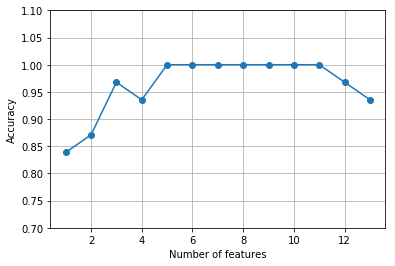

In [50]:
k_feat = [len(k) for k in sbs.subset]
plt.plot(k_feat, sbs.scores, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()